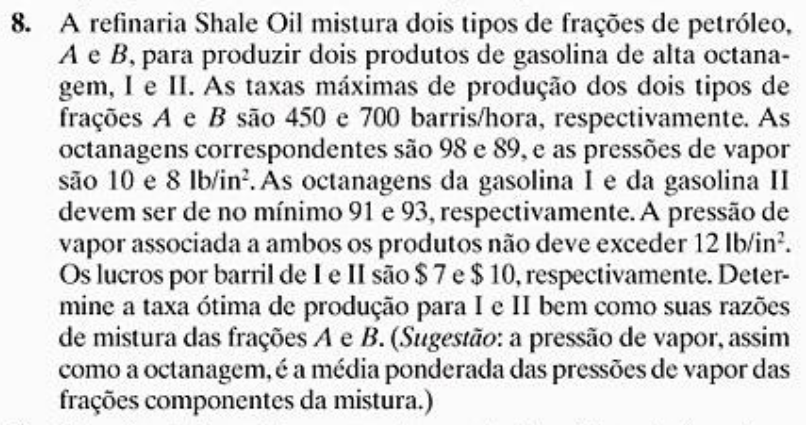

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Mistura_Gasolina_ShaleOil')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Identificadores
fracoes = ['A', 'B']
gasolinas = ['I', 'II']

# Disponibilidade das frações (barris/hora)
disponibilidade_fracao = {'A': 450, 'B': 700}

# Lucro por barril de gasolina final
lucro_gasolina = {'I': 7, 'II': 10}

# Propriedades das frações de entrada
octanagem_fracao = {'A': 98, 'B': 89}
pressao_vapor_fracao = {'A': 10, 'B': 8}

# Especificações das gasolinas de saída
octanagem_min_gas = {'I': 91, 'II': 93}
pressao_vapor_max_gas = {'I': 12, 'II': 12}

In [4]:
# 1. Variáveis de Decisão
# fluxo[f,g] = barris/hora da fração 'f' usados para produzir a gasolina 'g'
fluxo = model.continuous_var_matrix(fracoes, gasolinas, name='Fluxo', lb=0)


# 2. Função Objetivo
# Maximizar o lucro total. O lucro é por barril de gasolina final.
# A produção total de uma gasolina 'g' é a soma dos fluxos que a compõem.
expressao_lucro = (lucro_gasolina[g] * model.sum(fluxo[f,g] for f in fracoes)
                   for g in gasolinas)
lucro_total = model.sum(expressao_lucro)
model.maximize(lucro_total)


# 3. Restrições

# Restrição 1: Disponibilidade de cada Fração
# A soma do que é usado de uma fração não pode exceder sua disponibilidade.
for f in fracoes:
    expressao_uso_fracao = (fluxo[f,g] for g in gasolinas)
    soma_uso_fracao = model.sum(expressao_uso_fracao)
    restr_disponibilidade_logica = soma_uso_fracao <= disponibilidade_fracao[f]
    model.add_constraint(restr_disponibilidade_logica, ctname=f'disponibilidade_{f}')

# Restrição 2: Qualidade (Octanagem e Pressão de Vapor) para cada Gasolina
for g in gasolinas:
    # A soma total da gasolina 'g' é usada como denominador na média ponderada
    producao_total_gasolina = model.sum(fluxo[f,g] for f in fracoes)

    # Restrição de Octanagem Mínima
    # (Soma(oct_f * fluxo_fg)) / Soma(fluxo_fg) >= oct_min_g
    # ==> Soma(oct_f * fluxo_fg) >= oct_min_g * Soma(fluxo_fg)
    # ==> Soma((oct_f - oct_min_g) * fluxo_fg) >= 0
    expressao_octanagem = ((octanagem_fracao[f] - octanagem_min_gas[g]) * fluxo[f,g]
                           for f in fracoes)
    soma_octanagem_ponderada = model.sum(expressao_octanagem)
    restr_octanagem_logica = soma_octanagem_ponderada >= 0
    model.add_constraint(restr_octanagem_logica, ctname=f'octanagem_{g}')

    # Restrição de Pressão de Vapor Máxima
    # (Soma(pressao_f * fluxo_fg)) / Soma(fluxo_fg) <= pressao_max_g
    # ==> Soma((pressao_f - pressao_max_g) * fluxo_fg) <= 0
    expressao_pressao = ((pressao_vapor_fracao[f] - pressao_vapor_max_gas[g]) * fluxo[f,g]
                         for f in fracoes)
    soma_pressao_ponderada = model.sum(expressao_pressao)
    restr_pressao_logica = soma_pressao_ponderada <= 0
    model.add_constraint(restr_pressao_logica, ctname=f'pressao_vapor_{g}')

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    lucro_maximo = model.objective_value
    print(f"Lucro Máximo por Hora: ${lucro_maximo:,.2f}\n")

    print("--- Taxa de Produção e Razões de Mistura ---")
    for g in gasolinas:
        producao_total = sum(fluxo[f,g].solution_value for f in fracoes)
        if producao_total > 1e-6:
            print(f"\nGasolina {g}:")
            print(f"  - Produção Ótima: {producao_total:,.2f} barris/hora")
            print(f"  - Razão de Mistura:")
            for f in fracoes:
                fracao_val = fluxo[f,g].solution_value
                percentual = (fracao_val / producao_total) * 100
                print(f"    - Fração {f}: {fracao_val:,.2f} barris/hora ({percentual:.1f}%)")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 0 columns.
Aggregator did 1 substitutions.
Reduced LP has 3 rows, 3 columns, and 6 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =             9.999999
Iteration:     3   Dual objective     =         10675.000000

------ SOLUÇÃO ÓTIMA ------

Lucro Máximo por Hora: $10,675.00

--- Taxa de Produção e Razões de Mistura ---

Gasolina I:
  - Produção Ótima: 275.00 barris/hora
  - Razão de Mistura:
    - Fração A: 61.11 barris/hora (22.2%)
    - Fração B: 213.89 barris/hora (77.8%)

Gasolina II:
  - Produção Ótima: 875.00 barris/hora
  - Razão de Mistura:
    - Fração A: 388.89 barris/hora (44.4%)
    - Fração B: 486.11 barris/hora (55.6%)
